# SVC (Support Vector Classifier) on wine quality data

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('talk')
sns.set_style('white')

This dataset contains various chemical features of wine. There is also a quality metric that describes how high it is rated, and a wine color (red, or white).

The data has the following properties:
- 6497 entries
- 13 columns (11 float, 1 int, 1 object)
- All features are numbers. The target variable, color, is a categorical string variable

Below, we first explore the data and visualise some key metrics. Corelations between the features and target variable, and a general pair plot over all features, color coded by color category.

In [2]:
df = pd.read_csv("./data/Wine_Quality_Data.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         6497 non-null   float64
 1   volatile_acidity      6497 non-null   float64
 2   citric_acid           6497 non-null   float64
 3   residual_sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free_sulfur_dioxide   6497 non-null   float64
 6   total_sulfur_dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  color                 6497 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [24]:
df.describe()

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  \
count    6497.000000       6497.000000  6497.000000     6497.000000   
mean        7.215307          0.339666     0.318633        5.443235   
std         1.296434          0.164636     0.145318        4.757804   
min         3.800000          0.080000     0.000000        0.600000   
25%         6.400000          0.230000     0.250000        1.800000   
50%         7.000000          0.290000     0.310000        3.000000   
75%         7.700000          0.400000     0.390000        8.100000   
max        15.900000          1.580000     1.660000       65.800000   

         chlorides  free_sulfur_dioxide  total_sulfur_dioxide      density  \
count  6497.000000          6497.000000           6497.000000  6497.000000   
mean      0.056034            30.525319            115.744574     0.994697   
std       0.035034            17.749400             56.521855     0.002999   
min       0.009000             1.000000              6.000000     0.987110   
25%       0.038000            17.000000             77.000000     0.992340   
50%       0.047000            29.000000            118.000000     0.994890   
75%       0.065000            41.000000            156.000000     0.996990   
max       0.611000           289.000000            440.000000     1.038980   

                pH    sulphates      alcohol      quality  
count  6497.000000  6497.000000  6497.000000  6497.000000  
mean      3.218501     0.531268    10.491801     5.818378  
std       0.160787     0.148806     1.192712     0.873255  
min       2.720000     0.220000     8.000000     3.000000  
25%       3.110000     0.430000     9.500000     5.000000  
50%       3.210000     0.510000    10.300000     6.000000  
75%       3.320000     0.600000    11.300000     6.000000  
max       4.010000     2.000000    14.900000     9.000000

In [13]:
feature_column = 'color'

X = df.drop(columns=[feature_column])
y = (df[feature_column] == 'red').astype(int)

correlations = X.corrwith(y).sort_values()
correlations

total_sulfur_dioxide   -0.700357
free_sulfur_dioxide    -0.471644
residual_sugar         -0.348821
citric_acid            -0.187397
quality                -0.119323
alcohol                -0.032970
pH                      0.329129
density                 0.390645
fixed_acidity           0.486740
sulphates               0.487218
chlorides               0.512678
volatile_acidity        0.653036
dtype: float64

[(-1.0, 1.0), Text(0, 0.5, 'pearson correlation')]

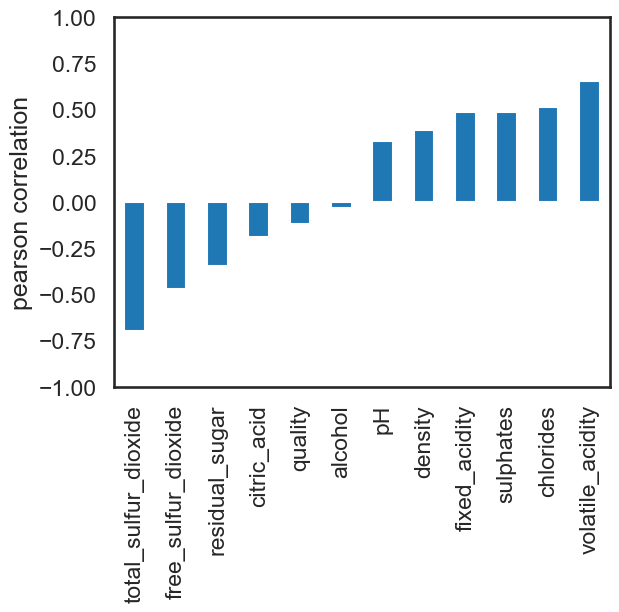

In [21]:
ax = correlations.plot.bar()
ax.set(ylim=[-1, 1], ylabel='pearson correlation')

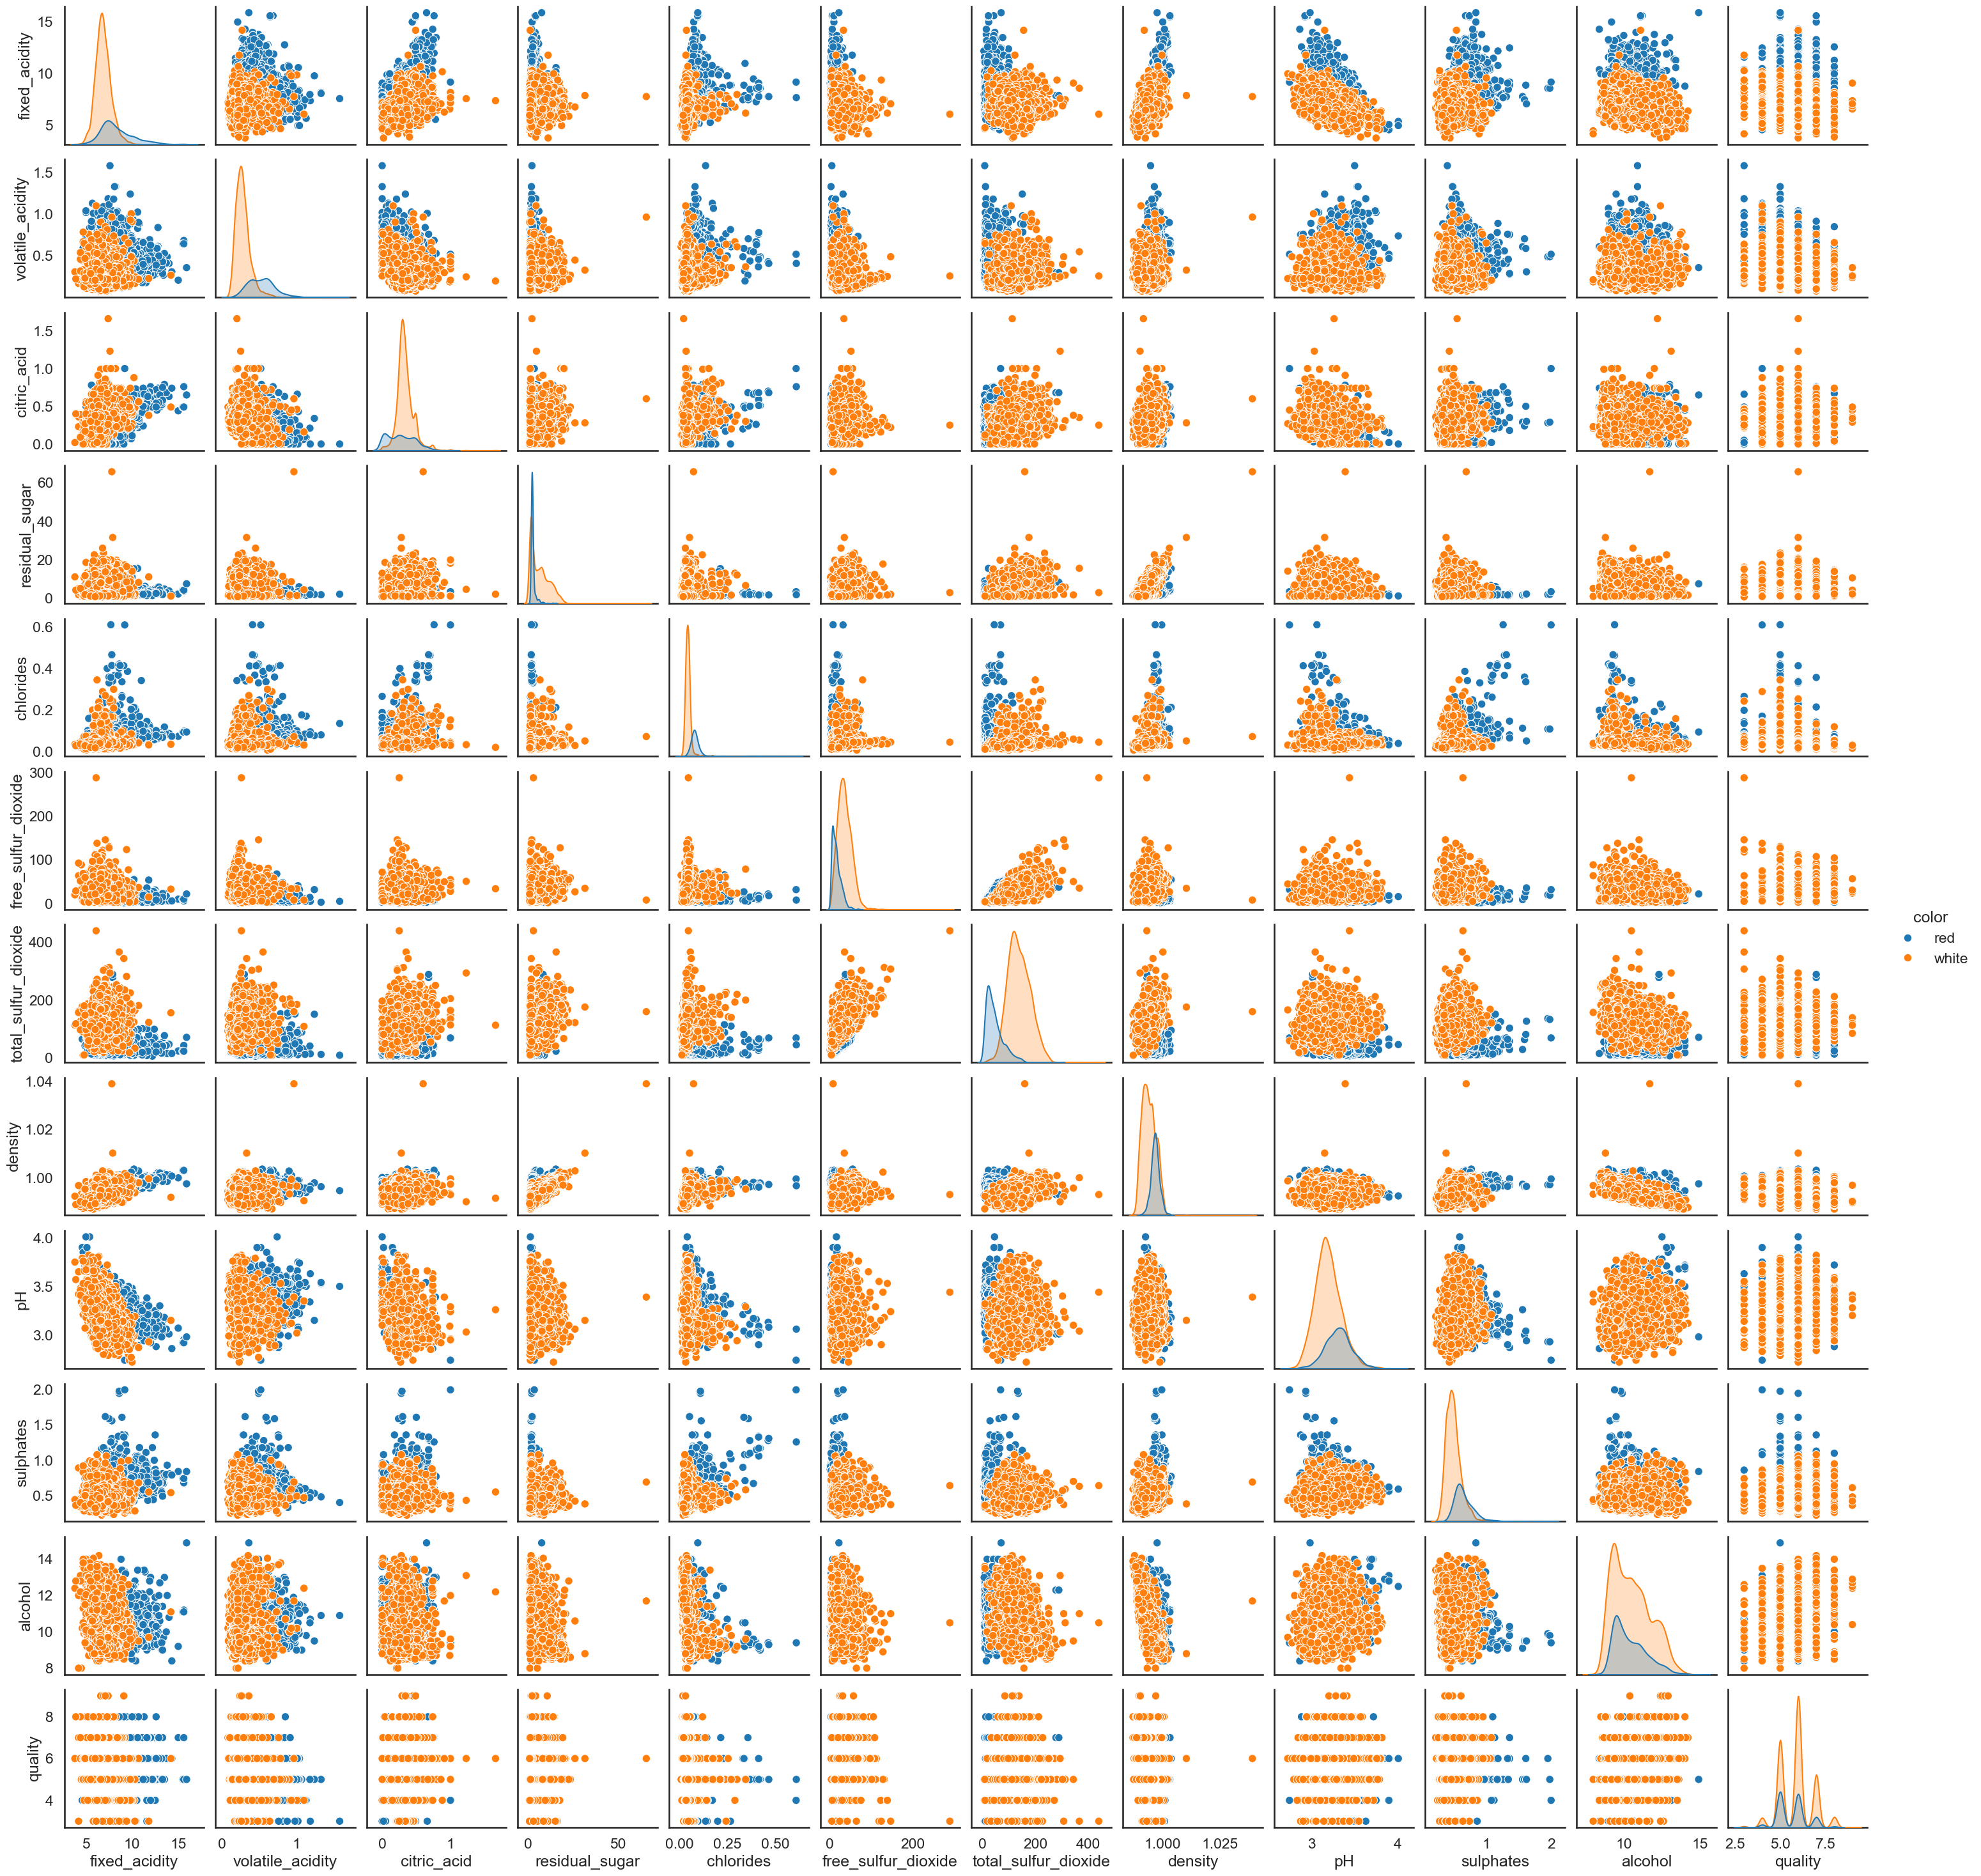

In [22]:
sns.pairplot(df, hue='color')

There are a lot of features that have significant overlap, for a simple linear model, it is expected that the predictive power will not be very good.

At the very least we first need to scale the features so our classifier is not too dependent on the original variable size. For our features we will take the two features with the highest correlation with the target variable. There is no specific reason for this, except that it will be easier to visualise a 2D model.

In [26]:
from sklearn.preprocessing import MinMaxScaler

fields = correlations.map(abs).sort_values().iloc[-2:].index
print(fields)
X = df[fields]
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X = pd.DataFrame(X, columns=['%s_scaled' % fld for fld in fields])

Index(['volatile_acidity', 'total_sulfur_dioxide'], dtype='object')


## Fitting a linear SVC

In [33]:
def plot_decision_boundary(estimator, X, y):
    estimator.fit(X, y)
    X_color = X.sample(300)
    y_color = y.loc[X_color.index]
    y_color = y_color.map(lambda r: 'red' if r == 1 else 'yellow')
    x_axis, y_axis = np.arange(0, 1, .005), np.arange(0, 1, .005)
    xx, yy = np.meshgrid(x_axis, y_axis)
    xx_ravel = xx.ravel()
    yy_ravel = yy.ravel()
    X_grid = pd.DataFrame([xx_ravel, yy_ravel]).T
    y_grid_predictions = estimator.predict(X_grid)
    y_grid_predictions = y_grid_predictions.reshape(xx.shape)

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.contourf(xx, yy, y_grid_predictions, cmap=plt.cm.autumn_r, alpha=.3)
    ax.scatter(X_color.iloc[:, 0], X_color.iloc[:, 1], color=y_color, alpha=1)
    ax.set(
        xlabel=fields[0],
        ylabel=fields[1],
        title=str(estimator))

p:\02_Poetry\Cache\virtualenvs\ibm-ml-sD2suF2h-py3.12\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearSVC was fitted with feature names
  warnings.warn(


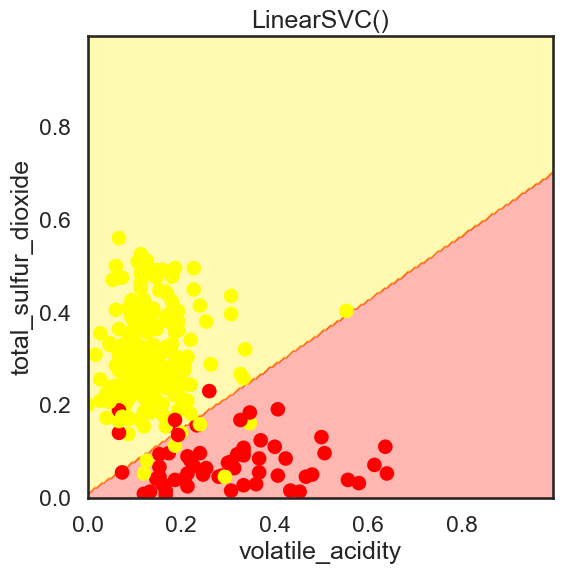

In [34]:
from sklearn.svm import LinearSVC

LSVC = LinearSVC()

plot_decision_boundary(LSVC, X, y)

This decision boundary looks fine, but it is clear that there are quite a few points near the coundary that are misclassified. Let;s see it a nonlinear kernel can help with this:

## Fitting a gaussian SVC

p:\02_Poetry\Cache\virtualenvs\ibm-ml-sD2suF2h-py3.12\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
p:\02_Poetry\Cache\virtualenvs\ibm-ml-sD2suF2h-py3.12\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
p:\02_Poetry\Cache\virtualenvs\ibm-ml-sD2suF2h-py3.12\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
p:\02_Poetry\Cache\virtualenvs\ibm-ml-sD2suF2h-py3.12\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


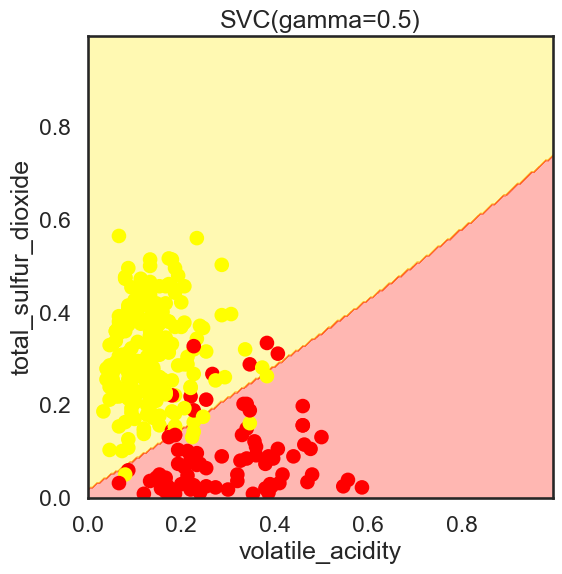

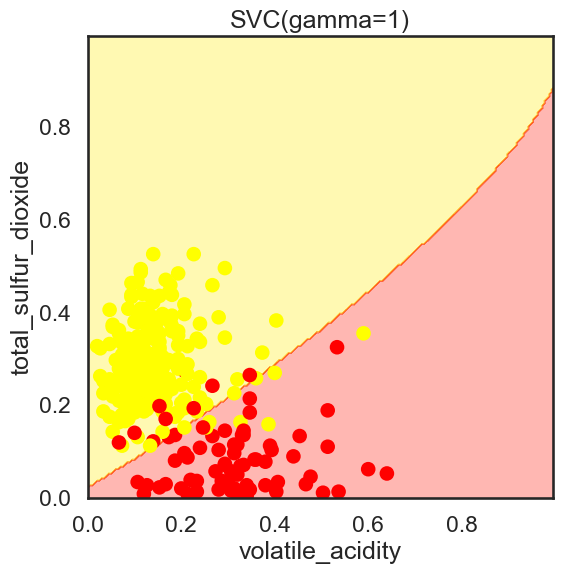

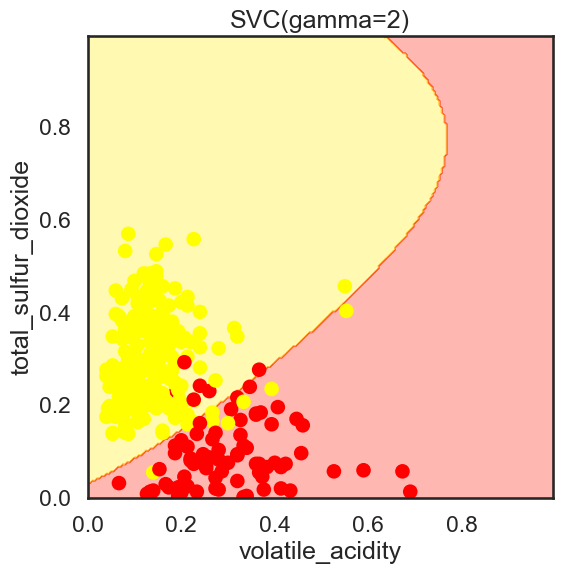

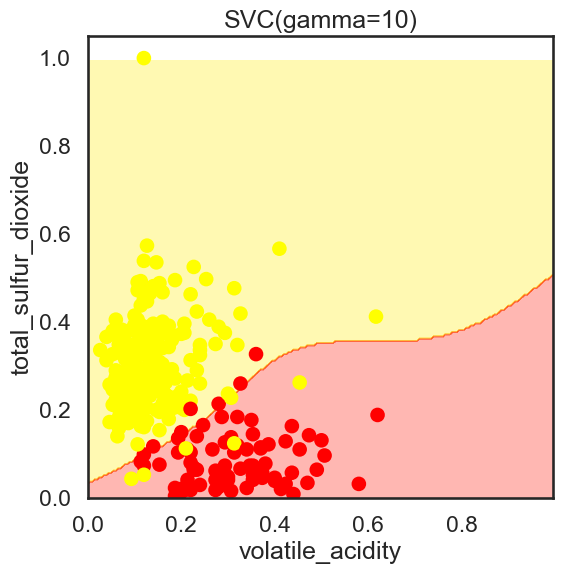

In [35]:
from sklearn.svm import SVC

gammas = [.5, 1, 2, 10]
for gamma in gammas:
    SVC_Gaussian = SVC(kernel='rbf', gamma=gamma)
    plot_decision_boundary(SVC_Gaussian, X, y)

p:\02_Poetry\Cache\virtualenvs\ibm-ml-sD2suF2h-py3.12\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
p:\02_Poetry\Cache\virtualenvs\ibm-ml-sD2suF2h-py3.12\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
p:\02_Poetry\Cache\virtualenvs\ibm-ml-sD2suF2h-py3.12\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


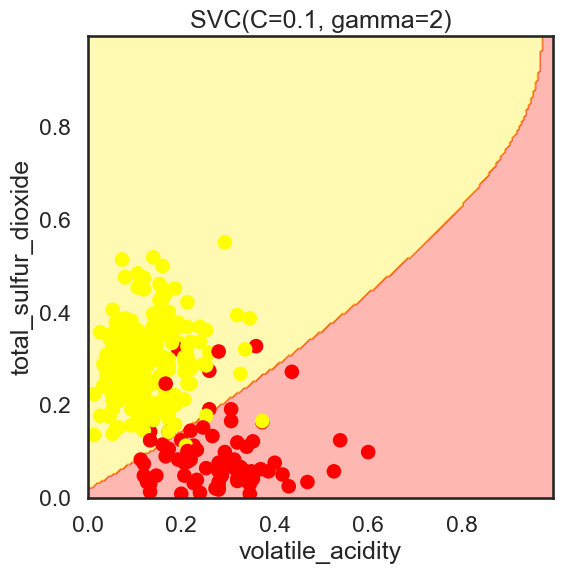

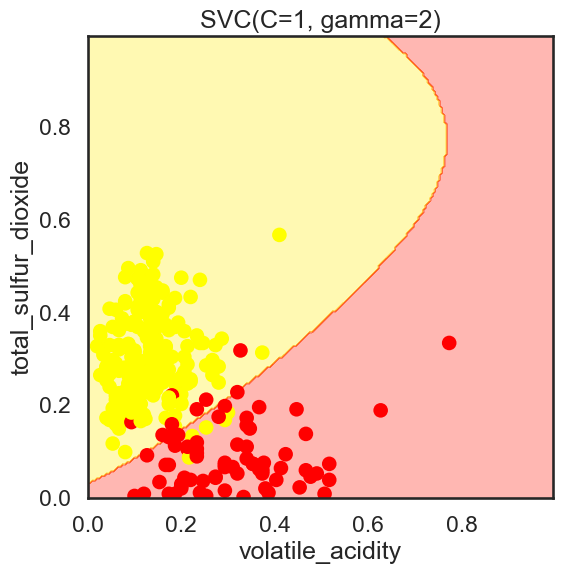

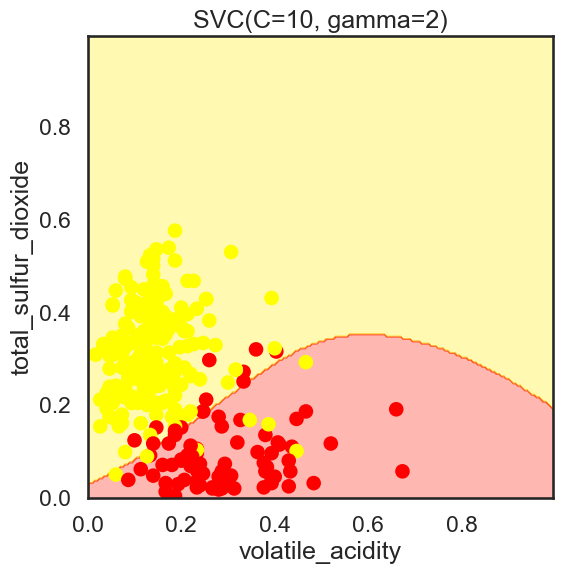

In [36]:
Cs = [.1, 1, 10]
for C in Cs:
    SVC_Gaussian = SVC(kernel='rbf', gamma=2, C=C)
    plot_decision_boundary(SVC_Gaussian, X, y)

So we get some curved decision boundaries that seem to capture a bti more of the feature distinction.

## Kernel execution times

In [37]:
from sklearn.kernel_approximation import Nystroem
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

y = df.color == 'red'
X = df[df.columns[:-1]]

kwargs = {'kernel': 'rbf'}
svc = SVC(**kwargs)
nystroem = Nystroem(**kwargs)
sgd = SGDClassifier()

In [40]:
%%timeit
svc.fit(X, y)

159 ms ± 1.92 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [41]:
%%timeit
X_transformed = nystroem.fit_transform(X)
sgd.fit(X_transformed, y)

40.4 ms ± 2.58 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [42]:
X2 = pd.concat([X]*5)
y2 = pd.concat([y]*5)

print(X2.shape)
print(y2.shape)

(32485, 12)
(32485,)


In [45]:
%%timeit 
svc.fit(X2, y2)

3.8 s ± 71 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [44]:
%%timeit
X2_transformed = nystroem.fit_transform(X2)
sgd.fit(X2_transformed, y2)

209 ms ± 12.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


From this we can see that the Nystroem method is *much* faster than the basic SVC method. Especially scaling with the data size, this effect is large. Nystroem uses only a subset of the input data to estimate a kernel and normalisation matrix. This process is much faster than just naively using the chosen kernel and reduces the complexity from $\mathcal{O}(n^3_{\text{samples}})$ to $\mathcal{O}(n^2_{\text{components}} \cdot n_{\text{samples}})$. 

More information on the Nystroem method can be found [Here](https://scikit-learn.org/stable/modules/kernel_approximation.html#nystroem-kernel-approx)